In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchts.nn.loss import quantile_loss
from torchts.nn.model import TimeSeriesModel

# Generate dataset

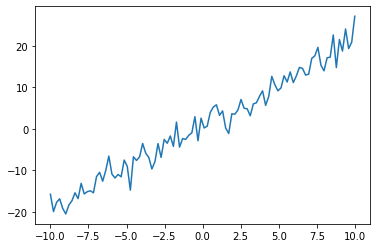

In [2]:
# generate linear time series data with some noise
x = np.linspace(-10,10,100).reshape(-1,1).astype(np.float32)
y = 2*x+1 + np.random.normal(0, 2, x.shape).reshape(-1,1).astype(np.float32)
plt.plot(x.flatten(), y.flatten())
plt.show()

# Enable uncertainty quantification in LSTM model

In [3]:
class LSTM(TimeSeriesModel):
    def __init__(self, input_size, output_size, optimizer, hidden_size=8, batch_size=10, **kwargs):
        super(LSTM, self).__init__(optimizer, **kwargs)
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.lstm = torch.nn.LSTMCell(input_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def init_hidden(self):
        # initialize the hidden state and the cell state to zeros
        return (
            torch.zeros(self.batch_size, self.hidden_size),
            torch.zeros(self.batch_size, self.hidden_size),
        )

    def forward(self, x, y=None, batches_seen=None):
        hc = self.init_hidden()
        hidden, _ = self.lstm(x, hc)
        out = self.linear(hidden)
        return out

# Train model to predict a single quantile

In [4]:
inputDim = 1
outputDim = 1
optimizer_args = {"lr": 0.01}
quantile = 0.5
batch_size = 10

model = LSTM(
    inputDim,
    outputDim,
    torch.optim.Adam,
    criterion=quantile_loss,
    criterion_args={"quantile": quantile},
    optimizer_args=optimizer_args,
)

In [5]:
# train model
model.fit(
    torch.from_numpy(x),
    torch.from_numpy(y),
    max_epochs=100,
    batch_size=batch_size,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type     | Params
------------------------------------
0 | lstm   | LSTMCell | 352   
1 | linear | Linear   | 9     
------------------------------------
361       Trainable params
0         Non-trainable params
361       Total params
0.001     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 144.93it/s, loss=0.847, v_num=156, train_loss_step=1.010, train_loss_epoch=0.841]


In [6]:
# inference
y_preds = None

for x_batch in torch.split(torch.from_numpy(x), batch_size):
    pred = model.predict(x_batch).detach().numpy()

    if y_preds is None:
        y_preds = pred
    else:
        y_preds = np.vstack([y_preds, pred])

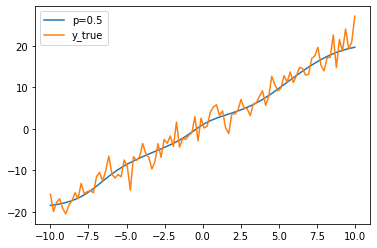

In [7]:
plt.plot(x.flatten(), y_preds.flatten(), label=f"p={quantile}")
plt.plot(x.flatten(), y.flatten(), label="y_true")
plt.legend()
plt.show()

# Train model to predict multiple quantiles

In [8]:
quantiles = [0.025, 0.5, 0.975]

model = LSTM(
    inputDim,
    outputDim * len(quantiles),
    torch.optim.Adam,
    criterion=quantile_loss,
    criterion_args={"quantile": quantiles},
    optimizer_args=optimizer_args,
)

In [9]:
# train model
model.fit(
    torch.from_numpy(x),
    torch.from_numpy(y),
    max_epochs=100,
    batch_size=batch_size,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type     | Params
------------------------------------
0 | lstm   | LSTMCell | 352   
1 | linear | Linear   | 27    
------------------------------------
379       Trainable params
0         Non-trainable params
379       Total params
0.002     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 210.66it/s, loss=1.1, v_num=157, train_loss_step=1.730, train_loss_epoch=1.110] 


In [10]:
# inference
y_preds = None

for x_batch in torch.split(torch.from_numpy(x), batch_size):
    pred = model.predict(x_batch).detach().numpy()

    if y_preds is None:
        y_preds = pred
    else:
        y_preds = np.vstack([y_preds, pred])

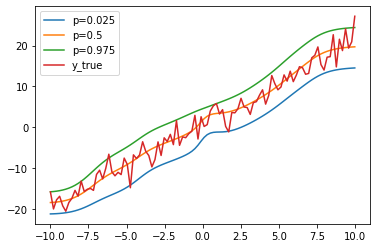

In [11]:
plt.plot(x.flatten(), y_preds, label=[f"p={q}" for q in quantiles])
plt.plot(x.flatten(), y.flatten(), label="y_true")
plt.legend()
plt.show()